In [5]:
%pylab inline
# Pandas is a nice utilitiy that enables some easy data manipulation, especially from a csv
import pandas as pd
# Numpy lets us work with arrays
import numpy as np
# Sklearn provides various modules with a common API
from sklearn import svm, tree, neighbors, neural_network, linear_model, ensemble
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit

# import pickle
import pickle

# other models
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# turn off warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fmin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
# Read in our csv files downloaded from Kaggle
train_data = pd.read_csv('train.csv').set_index("PassengerId")
test_data = pd.read_csv('test.csv').set_index("PassengerId")

In [7]:
# We can use .head() to get just the first few rows of the data.
train_data.head()
# Note how the notebook nicely displays the output for us

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
train_data.columns[train_data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

In [10]:
def parse_title(df):
    # title
    df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
    df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
    df['Title'] = df['Title'].replace('Ms','Miss')
    df['Title'] = df['Title'].replace('Mlle','Miss')
    df['Title'] = df['Title'].replace('Mme','Mrs')
    return df

def process_name(df):
    # parse title first
    df = parse_title(df)
    df['LastName'] = df.Name.str.split(',').str[0]
    # get information about sex from title
    df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
    return df

def add_family_info(df):
    family = df.groupby(df.LastName).Survived
    # count woman or boy
    df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
    # df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)
    df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
    # df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)
    df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)
    df.WomanOrBoyCount = df.WomanOrBoyCount.replace(np.nan, 0)
    df['Alone'] = (df.WomanOrBoyCount == 0)

    # Family_Size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    df['Single'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallF'] = df['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
    df['MedF'] = df['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    df['LargeF'] = df['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
    df.drop(columns = ['FamilySize'], inplace=True)
    return df

def fill_missing(df):
    # Embarked
    df['Embarked'] = df['Embarked'].fillna('S')
    # Cabin, Deck
    df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'
    # propogate median fair
    med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
    df['Fare'] = df['Fare'].fillna(med_fare)
    #Age
    df['Age'] = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))
    # family info
    df.WomanOrBoySurvived = df.WomanOrBoySurvived.fillna(0)
    df.WomanOrBoyCount = df.WomanOrBoyCount.fillna(0)
    df.FamilySurvivedCount = df.FamilySurvivedCount.fillna(0)
    df.Alone = df.Alone.fillna(0)
    return df    

In [11]:
def encode_types(df):
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    categorical_columns = []
    features = df.columns.values.tolist()
    for col in features:
        if df[col].dtype in numerics: continue
        categorical_columns.append(col)
    # Encoding categorical features
    for col in categorical_columns:
        if col in df.columns:
            le = LabelEncoder()
            le.fit(list(df[col].astype(str).values))
            df[col] = le.transform(list(df[col].astype(str).values))
    return df
    

In [12]:
RANDOM_SEED = 10

# combine train and test into single df for preprocessing --> becareful bc test won't have survived column
df = pd.concat([train_data, test_data], axis=0, sort=False)
df.head()

df = process_name(df)

df = add_family_info(df)

# fill in missing
df = fill_missing(df)

# drop these columns
cols_to_drop = ['Name','Ticket','Cabin']
df = df.drop(cols_to_drop, axis=1)

# encode the string datatypes using LabelEncoder
df = encode_types(df)

# separate into data and survived label
train_data, test_data = df.loc[train_data.index], df.loc[test_data.index]
X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

test_data = test_data.loc[:, test_data.columns != 'Survived']
print(test_data.head())

# try kfold from scikit-learn
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=RANDOM_SEED)

# print(X_train.head())
# print(y_train.head())
# print(test_data.head())

             Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title  \
PassengerId                                                              
892               3    1  34.5      0      0   7.8292         1     10   
893               3    0  47.0      1      0   7.0000         2     11   
894               2    1  62.0      0      0   9.6875         1     10   
895               3    1  27.0      0      0   8.6625         2     10   
896               3    0  22.0      1      1  12.2875         2     11   

             LastName  IsWomanOrBoy  WomanOrBoyCount  FamilySurvivedCount  \
PassengerId                                                                 
892               401             0                3                  3.0   
893               846             1                1                  0.0   
894               552             0                0                  0.0   
895               854             0                0                  0.0   
896               3

In [13]:
train_data.columns[train_data.isna().any()].tolist()
train_data[train_data['Embarked'].isna() == True]
#train_data['Embarked']
#test_data.columns[test_data.isna().any()].tolist()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,LastName,IsWomanOrBoy,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Single,SmallF,MedF,LargeF,Deck
PassengerId,,,,,,,,,,,,,,,,,,,,


## Keeping track of models

For now we will keep a dictionary with all the models performance

Model will map to (fnr, fpr)

Next we will pickle them so we don't have to waste time retraining

In [14]:
'''
Use this method to score the cross evaluation
This way we will have the confusion matrix values for each fold and we can easily get the average fnr and fpr
'''
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    accuracy = clf.score(X, y)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1], "acc": accuracy}

# fit and evaluate model
def eval(model):
    # cross validation --> generate different train test splits
    
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=RANDOM_SEED)

    model.fit(X_train.values, y_train.values)

    # cross eval accuracy
    score = cross_validate(model, X_train.values, y_train.values, cv = cv, scoring=confusion_matrix_scorer)
    print(score)

    tn = np.mean(score['test_tn'])
    fp = np.mean(score['test_fp'])
    fn = np.mean(score['test_fn'])
    tp = np.mean(score['test_tp'])
    acc = np.mean(score['test_acc'])

    print("Accuracy", acc)
    print("")
    print("True Negatives", tn)
    print("False Positives", fp)
    print("False Negatives", fn)
    print("True Positives", tp)
    print("")
    fpr = fp / (fp + tn)
    print("FPR", fpr)
    fnr = fn / (fn + tp)
    print("FNR", fnr)
    models[type(model).__name__] = (fpr, fnr)

In [15]:
models = {}

## Tree

In [16]:
tree_clf = tree.DecisionTreeClassifier()
eval(tree_clf)

{'fit_time': array([0.00287867, 0.00199986, 0.00178528, 0.00185394, 0.00171924]), 'score_time': array([0.00181603, 0.00106192, 0.00099111, 0.0010345 , 0.00095034]), 'test_tn': array([138, 134, 152, 143, 142]), 'test_fp': array([36, 32, 20, 22, 19]), 'test_fn': array([19, 19, 14, 15, 31]), 'test_tp': array([75, 83, 82, 88, 76]), 'test_acc': array([0.79477612, 0.80970149, 0.87313433, 0.8619403 , 0.81343284])}
Accuracy 0.8305970149253732

True Negatives 141.8
False Positives 25.8
False Negatives 19.6
True Positives 80.8

FPR 0.1539379474940334
FNR 0.1952191235059761


## KNN

In [17]:
knn_clf = neighbors.KNeighborsClassifier()
eval(knn_clf)

{'fit_time': array([0.00340509, 0.00065827, 0.00067163, 0.00066447, 0.00068569]), 'score_time': array([0.02462101, 0.02339745, 0.02370071, 0.02297068, 0.02289033]), 'test_tn': array([146, 135, 146, 137, 135]), 'test_fp': array([28, 31, 26, 28, 26]), 'test_fn': array([53, 62, 57, 62, 70]), 'test_tp': array([41, 40, 39, 41, 37]), 'test_acc': array([0.69776119, 0.65298507, 0.69029851, 0.6641791 , 0.64179104])}
Accuracy 0.6694029850746268

True Negatives 139.8
False Positives 27.8
False Negatives 60.8
True Positives 39.6

FPR 0.16587112171837706
FNR 0.6055776892430278


## NN

In [18]:
NN_clf = neural_network.MLPClassifier()
eval(NN_clf)

{'fit_time': array([0.35326648, 0.34323025, 0.16595697, 0.16378331, 0.31392336]), 'score_time': array([0.00191331, 0.0017755 , 0.00191164, 0.00183821, 0.00190473]), 'test_tn': array([167, 143, 160, 152, 134]), 'test_fp': array([ 7, 23, 12, 13, 27]), 'test_fn': array([25, 23, 26, 23, 26]), 'test_tp': array([69, 79, 70, 80, 81]), 'test_acc': array([0.88059701, 0.82835821, 0.85820896, 0.86567164, 0.80223881])}
Accuracy 0.8470149253731343

True Negatives 151.2
False Positives 16.4
False Negatives 24.6
True Positives 75.8

FPR 0.09785202863961813
FNR 0.2450199203187251


## SVM

In [19]:
svm_clf = svm.SVC(kernel='linear')
eval(svm_clf)

{'fit_time': array([37.64612889, 29.58378482, 18.18182015, 15.95674253, 39.15144515]), 'score_time': array([0.00301409, 0.00314999, 0.00307918, 0.00286007, 0.00287819]), 'test_tn': array([172, 164, 170, 162, 161]), 'test_fp': array([2, 2, 2, 3, 0]), 'test_fn': array([21, 23, 24, 24, 33]), 'test_tp': array([73, 79, 72, 79, 74]), 'test_acc': array([0.9141791 , 0.90671642, 0.90298507, 0.89925373, 0.87686567])}
Accuracy 0.9

True Negatives 165.8
False Positives 1.8
False Negatives 25.0
True Positives 75.4

FPR 0.010739856801909307
FNR 0.249003984063745


In [20]:
svm_linear = svm.LinearSVC()
eval(svm_linear)

{'fit_time': array([0.02663469, 0.02491474, 0.02533221, 0.02509713, 0.02731872]), 'score_time': array([0.00230145, 0.00174117, 0.00182796, 0.00183845, 0.00124764]), 'test_tn': array([119, 155,   3, 155, 145]), 'test_fp': array([ 55,  11, 169,  10,  16]), 'test_fn': array([17, 27,  0, 36, 24]), 'test_tp': array([77, 75, 96, 67, 83]), 'test_acc': array([0.73134328, 0.85820896, 0.36940299, 0.82835821, 0.85074627])}
Accuracy 0.7276119402985075

True Negatives 115.4
False Positives 52.2
False Negatives 20.8
True Positives 79.6

FPR 0.3114558472553699
FNR 0.2071713147410359


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

## Linear

In [21]:
logistic = linear_model.LogisticRegression()
eval(logistic)

{'fit_time': array([0.03676724, 0.0431881 , 0.02990341, 0.02949715, 0.02837849]), 'score_time': array([0.00135064, 0.00134277, 0.00140858, 0.0013051 , 0.0013001 ]), 'test_tn': array([166, 155, 153, 154, 153]), 'test_fp': array([ 8, 11, 19, 11,  8]), 'test_fn': array([21, 23, 23, 23, 30]), 'test_tp': array([73, 79, 73, 80, 77]), 'test_acc': array([0.89179104, 0.87313433, 0.84328358, 0.87313433, 0.85820896])}
Accuracy 0.867910447761194

True Negatives 156.2
False Positives 11.4
False Negatives 24.0
True Positives 76.4

FPR 0.06801909307875896
FNR 0.2390438247011952


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [22]:
perceptron = linear_model.Perceptron()
eval(perceptron)

{'fit_time': array([0.0014503 , 0.0050776 , 0.00144529, 0.00131941, 0.00204754]), 'score_time': array([0.00124574, 0.00256848, 0.00139117, 0.00114465, 0.00114012]), 'test_tn': array([173, 163, 170,  16, 161]), 'test_fp': array([  1,   3,   2, 149,   0]), 'test_fn': array([69, 90, 89,  8, 98]), 'test_tp': array([25, 12,  7, 95,  9]), 'test_acc': array([0.73880597, 0.65298507, 0.66044776, 0.4141791 , 0.63432836])}
Accuracy 0.6201492537313433

True Negatives 136.6
False Positives 31.0
False Negatives 70.8
True Positives 29.6

FPR 0.18496420047732698
FNR 0.7051792828685258


In [23]:
ridge = linear_model.RidgeClassifier()
eval(ridge)

{'fit_time': array([0.00215054, 0.00187516, 0.00186872, 0.00180984, 0.0018158 ]), 'score_time': array([0.00121737, 0.00115776, 0.00115371, 0.00114441, 0.00114274]), 'test_tn': array([169, 158, 169, 158, 158]), 'test_fp': array([5, 8, 3, 7, 3]), 'test_fn': array([18, 24, 23, 21, 29]), 'test_tp': array([76, 78, 73, 82, 78]), 'test_acc': array([0.9141791 , 0.88059701, 0.90298507, 0.89552239, 0.88059701])}
Accuracy 0.894776119402985

True Negatives 162.4
False Positives 5.2
False Negatives 23.0
True Positives 77.4

FPR 0.03102625298329356
FNR 0.2290836653386454


In [24]:
sdg = linear_model.SGDClassifier()
eval(sdg)

{'fit_time': array([0.00413585, 0.0039115 , 0.00441289, 0.00414681, 0.00423241]), 'score_time': array([0.00132632, 0.00138211, 0.00144124, 0.00131607, 0.00132799]), 'test_tn': array([  8,   6, 166, 160, 160]), 'test_fp': array([166, 160,   6,   5,   1]), 'test_fn': array([ 1,  2, 79, 92, 88]), 'test_tp': array([ 93, 100,  17,  11,  19]), 'test_acc': array([0.37686567, 0.39552239, 0.68283582, 0.6380597 , 0.66791045])}
Accuracy 0.5522388059701492

True Negatives 100.0
False Positives 67.6
False Negatives 52.4
True Positives 48.0

FPR 0.4033412887828162
FNR 0.5219123505976095


## Ensemble

In [25]:
random_forest = ensemble.RandomForestClassifier()
eval(random_forest)

{'fit_time': array([0.14390659, 0.12190008, 0.1191082 , 0.12938643, 0.11927938]), 'score_time': array([0.02403402, 0.02309251, 0.0252111 , 0.02339292, 0.02210712]), 'test_tn': array([170, 158, 167, 159, 154]), 'test_fp': array([4, 8, 5, 6, 7]), 'test_fn': array([20, 21, 20, 22, 29]), 'test_tp': array([74, 81, 76, 81, 78]), 'test_acc': array([0.91044776, 0.89179104, 0.90671642, 0.89552239, 0.86567164])}
Accuracy 0.8940298507462687

True Negatives 161.6
False Positives 6.0
False Negatives 22.4
True Positives 78.0

FPR 0.03579952267303103
FNR 0.2231075697211155


In [26]:
gradient_boost = ensemble.GradientBoostingClassifier()
eval(gradient_boost)

{'fit_time': array([0.1114707 , 0.11102843, 0.10378528, 0.10727787, 0.1025331 ]), 'score_time': array([0.00205231, 0.00215459, 0.00268865, 0.00206542, 0.00231552]), 'test_tn': array([169, 158, 168, 157, 156]), 'test_fp': array([5, 8, 4, 8, 5]), 'test_fn': array([21, 22, 18, 19, 29]), 'test_tp': array([73, 80, 78, 84, 78]), 'test_acc': array([0.90298507, 0.8880597 , 0.91791045, 0.89925373, 0.87313433])}
Accuracy 0.896268656716418

True Negatives 161.6
False Positives 6.0
False Negatives 21.8
True Positives 78.6

FPR 0.03579952267303103
FNR 0.2171314741035857


In [27]:
extra_trees = ensemble.ExtraTreesClassifier()
eval(extra_trees)

{'fit_time': array([0.09944367, 0.09411883, 0.09056544, 0.08917069, 0.09177423]), 'score_time': array([0.02510524, 0.02380276, 0.02410817, 0.02481842, 0.0247221 ]), 'test_tn': array([162, 156, 165, 157, 151]), 'test_fp': array([12, 10,  7,  8, 10]), 'test_fn': array([20, 19, 19, 22, 29]), 'test_tp': array([74, 83, 77, 81, 78]), 'test_acc': array([0.88059701, 0.89179104, 0.90298507, 0.8880597 , 0.85447761])}
Accuracy 0.8835820895522388

True Negatives 158.2
False Positives 9.4
False Negatives 21.8
True Positives 78.6

FPR 0.05608591885441528
FNR 0.2171314741035857


In [28]:
bagging = ensemble.BaggingClassifier()
eval(bagging)

{'fit_time': array([0.0200119 , 0.02312255, 0.01897812, 0.0214684 , 0.02229619]), 'score_time': array([0.00349045, 0.00357699, 0.00344706, 0.00353026, 0.00332475]), 'test_tn': array([169, 155, 165, 153, 154]), 'test_fp': array([ 5, 11,  7, 12,  7]), 'test_fn': array([20, 19, 17, 19, 31]), 'test_tp': array([74, 83, 79, 84, 76]), 'test_acc': array([0.90671642, 0.8880597 , 0.91044776, 0.88432836, 0.85820896])}
Accuracy 0.8895522388059701

True Negatives 159.2
False Positives 8.4
False Negatives 21.2
True Positives 79.2

FPR 0.05011933174224344
FNR 0.21115537848605576


## Random Forest

In [29]:
random_forest = GridSearchCV(estimator=ensemble.RandomForestClassifier(), param_grid={'n_estimators': [200, 300, 400, 500]}, cv=10).fit(X_train, y_train)
random_forest.fit(X_train, y_train)
acc = random_forest.score(X_train, y_train)
# find best paremeters
# print(acc,random_forest.best_params_)

random_forest = ensemble.RandomForestClassifier(n_estimators = 500)
eval(random_forest)

{'fit_time': array([0.59699512, 0.58047915, 0.59192681, 0.5916481 , 0.58535242]), 'score_time': array([0.10458159, 0.10410762, 0.10512114, 0.10853887, 0.10558772]), 'test_tn': array([170, 158, 168, 159, 157]), 'test_fp': array([4, 8, 4, 6, 4]), 'test_fn': array([21, 20, 19, 23, 29]), 'test_tp': array([73, 82, 77, 80, 78]), 'test_acc': array([0.90671642, 0.89552239, 0.9141791 , 0.89179104, 0.87686567])}
Accuracy 0.8970149253731343

True Negatives 162.4
False Positives 5.2
False Negatives 22.4
True Positives 78.0

FPR 0.03102625298329356
FNR 0.2231075697211155


## XGB

In [30]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score 

space_xgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth':  hp.choice('max_depth', np.arange(5, 8, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1,
            'missing': None
        }

# best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)

# params = space_eval(space_xgb, best)

xgb_clf = XGBClassifier()
# xgb_clf.fit(X_train, y_train)
# acc = xgb_clf.score(X_train, y_train)
# print("Accuracy", acc)
eval(xgb_clf)

{'fit_time': array([0.03857446, 0.03917599, 0.03811359, 0.0376792 , 0.03917599]), 'score_time': array([0.00243306, 0.00221705, 0.00223565, 0.0023222 , 0.00229931]), 'test_tn': array([169, 157, 166, 158, 157]), 'test_fp': array([5, 9, 6, 7, 4]), 'test_fn': array([21, 23, 21, 19, 31]), 'test_tp': array([73, 79, 75, 84, 76]), 'test_acc': array([0.90298507, 0.88059701, 0.89925373, 0.90298507, 0.86940299])}
Accuracy 0.891044776119403

True Negatives 161.4
False Positives 6.2
False Negatives 23.0
True Positives 77.4

FPR 0.0369928400954654
FNR 0.2290836653386454


In [31]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def show_matrix(model):
    y_pred = model.cross_validate_predict(X)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_truth, y_pred)
    class_names=['0', '1']
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title='Confusion matrix, without normalization')

    plt.show()

#  show_matrix(knn_clf)

In [41]:
def create_pred_csv(model):
    predictions = model.predict(test_data.values).astype(int)
    pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
    type(pred_df)
    pred_df.to_csv(type(model).__name__ + 'predictions.csv', header=True, sep=',')


# think the test_data has NaN so it really doesn't like it
create_pred_csv(tree_clf)

## Function to display pareto front

We will give it the model dict and all the fpr and fnr that we have

https://oapackage.readthedocs.io/en/latest/examples/example_pareto.html

https://stackoverflow.com/questions/21294829/fast-calculations-of-the-pareto-front-in-r

The trick here is to sort by x, which then allows you to limit your check to making sure that all prior values of x must have greater values of y to ensure that point is on the frontier.

In [33]:
def create_models_df(models):
    df = pd.DataFrame(columns = ['model', 'fpr', 'fnr'])
    for model in models:
        fpr, fnr = models[model]
        df.loc[len(df.index)] = [model, fpr, fnr]
    return df

def find_hof(df):
    out = {}
    for index, row in df.iterrows():
        # look at all the models with a higher fpr
        tmp = df[df.fpr < row['fpr']]
        # drop the ones with a higher fnr
        tmp = tmp[tmp.fnr <= row['fnr']]
        # not optimal
        if len(tmp)  == 0:
            model = row['model']
            fpr = row['fpr']
            fnr = row['fnr']
            out[model] = (fpr, fnr)
    return out


df = create_models_df(models)
hof = find_hof(df)
print(hof)


{'DecisionTreeClassifier': (0.1539379474940334, 0.1952191235059761), 'SVC': (0.010739856801909307, 0.249003984063745), 'RidgeClassifier': (0.03102625298329356, 0.2290836653386454), 'RandomForestClassifier': (0.03102625298329356, 0.2231075697211155), 'GradientBoostingClassifier': (0.03579952267303103, 0.2171314741035857), 'BaggingClassifier': (0.05011933174224344, 0.21115537848605576)}


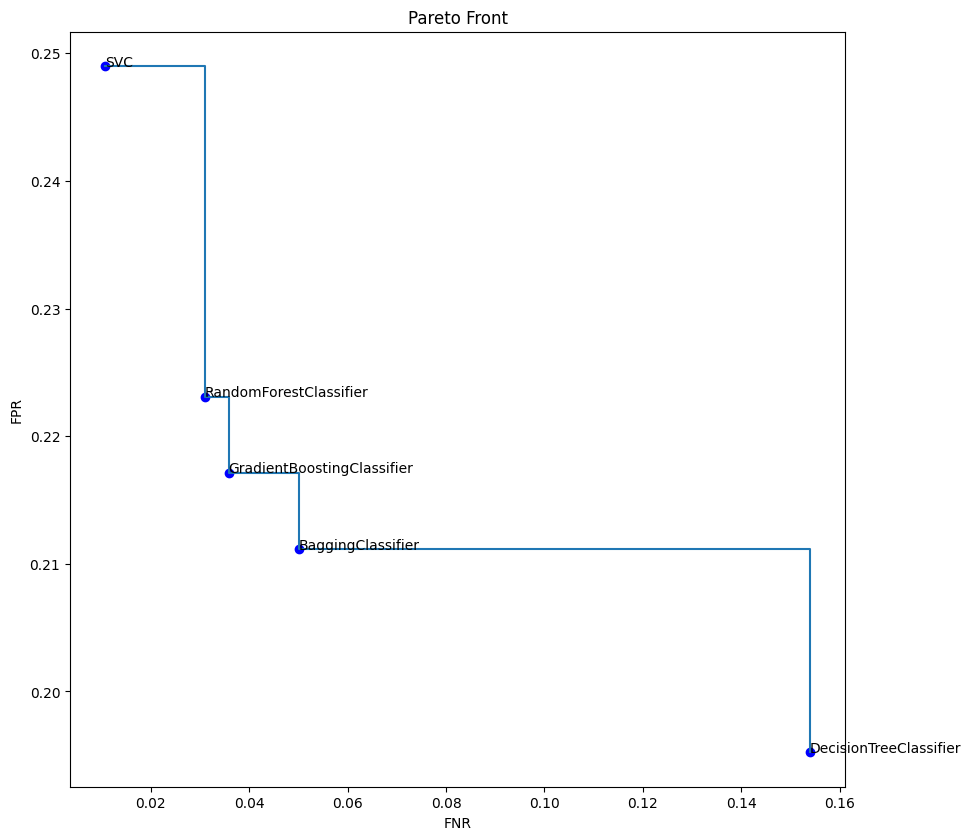

In [34]:
def pareto_frontier(models):
    dominated = []
    pareto = []
    for model in models:
        fnr, fpr = models[model]
        if pareto:
            classified = False
            for curr_model in pareto:
                curr_fnr, curr_fpr = models[curr_model]
                if (curr_fnr <= fnr and curr_fpr < fpr) or (curr_fnr < fnr and curr_fpr <= fpr):
                    dominated.append(model)
                    classified = True
                elif (curr_fnr >= fnr and curr_fpr > fpr) or (curr_fnr > fnr and curr_fpr >= fpr):
                    dominated.append(curr_model)
                    pareto.remove(curr_model)
            if not classified:
                pareto.append(model)
        else:
            pareto.append(model)
                
    fnr = []
    fpr = []
    for model in pareto:
        cfnr, cfpr = models[model]
        i = 0
        while i < len(fnr):
            if cfnr > fnr[i]:
                i += 1
            else:
                break
        fnr.insert(i, cfnr)
        fpr.insert(i, cfpr)

    plt.figure(figsize=(10, 10), dpi=100)
    plt.step(fnr, fpr, where='post', label = 'post')
    for model in pareto:
        curr_fnr, curr_fpr = models[model]
        plt.scatter(curr_fnr, curr_fpr, color='b')
        plt.annotate(str(model), (curr_fnr, curr_fpr))
    plt.xlabel("FNR")
    plt.ylabel("FPR")
    plt.title("Pareto Front")
pareto_frontier(models)